In [1]:
import json
import os
import pickle
from collections import defaultdict, Counter

### Exploring Data

In [2]:
data_dir = '../data_dir'
datafile = os.path.join(data_dir, 'doordash_categorized.pkl')
print(datafile)
with open(datafile, 'rb') as f:
    json = pickle.load(f)
examples_title = []
examples_cuisine = []
for entry in json:
    title = entry['title']
    label = entry['labels']['category']
    examples_title.append(title)
    examples_cuisine.append(label)

../data_dir/doordash_categorized.pkl


In [3]:
cuisines = list(sorted(set(examples_cuisine)))

In [4]:
cuisines

['african',
 'american',
 'asian',
 'belgian',
 'british',
 'burmese',
 'caribbean',
 'chinese',
 'eastern_european',
 'ethiopian',
 'european',
 'filipino',
 'french',
 'german',
 'greek',
 'indian',
 'irish',
 'italian',
 'japanese',
 'korean',
 'latin_american',
 'mediterranean',
 'mexican',
 'middle_eastern',
 'other',
 'south_asian',
 'southern',
 'spanish',
 'thai',
 'vietnamese']

In [8]:
pickle.dump(cuisines, open('../data_dir/cuisines_ordered_list.pkl', 'wb'))

In [ ]:
# mexican, chinese, american, italian, thai, indian, japanese, other

In [ ]:
Counter(examples_cuisine).most_common()

### Exploring Embeddings

In [47]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn.linear_model

In [6]:
encodings = torch.load('../output_dirs/classification_test/checkpoint-4500/model_encodings')

In [7]:
labels = torch.load('../output_dirs/classification_test/checkpoint-4500/labels')

In [8]:
encodings.shape

(396321, 768)

In [24]:
restrict_labels = [1, 7, 15, 17, 18, 22, 24, 28]
# american, chinese, indian, italian, japanese, mexican, other, thai
# restrict_labels = [1, 7, 15, 17, 18, 22, 28]
# restrict_labels = [24, 28]
idx = np.isin(labels, restrict_labels)
res_encodings = encodings[idx]
res_labels = labels[idx]
translated_labels = [restrict_labels.index(l) for l in res_labels]
cuisine_names = [cuisines[l] for l in restrict_labels]

In [10]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(res_encodings)

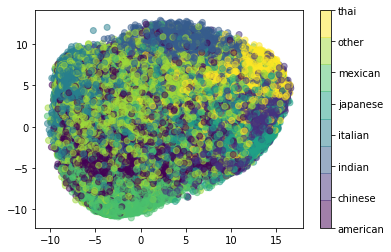

In [29]:
plt.scatter(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    c=translated_labels,
    alpha=0.5,
    cmap=plt.cm.get_cmap('viridis', 8)
)
cb = plt.colorbar()
cb.ax.set_yticklabels([cuisines[restrict_labels[int(i)]] for i in cb.get_ticks()])
plt.show()

In [36]:
N = 10000
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result[:N, :30])

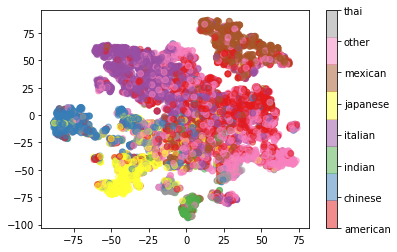

In [44]:
plt.scatter(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    c=translated_labels[:N],
    alpha=0.5,
    cmap=plt.cm.get_cmap('Set1', 8)
)
cb = plt.colorbar()
cb.ax.set_yticklabels([cuisines[restrict_labels[int(i)]] for i in cb.get_ticks()])
plt.show()

#### Linear Regression

In [66]:
restrict_labels = [1, 7, 15, 17, 18, 22, 24, 28]
restrict_labels = [1, 7, 15, 17, 18, 22, 28]
# american, chinese, indian, italian, japanese, mexican, other, thai
# restrict_labels = [1, 7, 15, 17, 18, 22, 28]
# restrict_labels = [24, 28]
idx = np.isin(labels, restrict_labels)
res_encodings = encodings[idx]
res_labels = labels[idx]

In [67]:
lr = sklearn.linear_model.LogisticRegression()
lr.fit(res_encodings, res_labels)

/home/uma_roy_us_gmail_com/.local/share/virtualenvs/transformers-_CUu7l8n/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [68]:
pred_labels = lr.predict(res_encodings)

In [69]:
lr.score(res_encodings, res_labels)

0.7265063413131709

In [70]:
import sklearn.metrics
print(sklearn.metrics.classification_report(res_labels, pred_labels))

              precision    recall  f1-score   support

           1       0.63      0.67      0.65     51392
           7       0.73      0.79      0.76     25077
          15       0.83      0.78      0.80      6788
          17       0.78      0.76      0.77     51917
          18       0.77      0.74      0.75     25178
          22       0.78      0.77      0.77     31785
          28       0.63      0.48      0.55      9162

    accuracy                           0.73    201299
   macro avg       0.73      0.71      0.72    201299
weighted avg       0.73      0.73      0.73    201299



In [71]:
wrong = (pred_labels != res_labels)

In [83]:
example_titles_idx = []
ec = []
for pos, i in enumerate(idx):
    if i:
        example_titles_idx.append(examples_title[pos])
        ec.append(examples_cuisine[pos])

In [86]:
p = 0
for i, w in enumerate(wrong):
    if w:
        print(example_titles_idx[i],
              #ec[i],
             cuisines[res_labels[i]],
             cuisines[pred_labels[i]])
        p += 1
    if p > 100:
        break


Pure Leaf Tea Bottle mexican american
Chicken Alfredo chinese italian
Small Garden Salad american italian
C's Cheese Quesadilla american mexican
Steamed Dumplings american chinese
Appam indian american
E13. Orange Chicken thai chinese
Fried Shrimp & Calamari italian american
Pan Fried Chives Dumplings (Medium) japanese chinese
Big Fat Greek Gyro Sandwich italian american
S24. Shrimp and Scallops with Hot Pepper Sauce japanese chinese
SautÃ©ed Shrimp italian american
Double Cheeseburger Deluxe italian american
Avocado Kama chinese japanese
Hot Love japanese american
Cold Tea japanese american
Cheeseburger Triple Decker Club italian american
Eggplant Rollantine american italian
Pepper Steak Sandwich Platter american italian
Meatball Marinara american italian
1 Topping Pizza 16" american italian
Mushroom Bolognese american italian
Filet of Sole Capricciosa american italian
Fruit Tray Half mexican american
DS2. Bonjour Cheese Cake japanese chinese
Crispy Brussels mexican american
Crispy Bu

#### Linear Regression other vs. rest

In [87]:
restrict_labels = [1, 7, 15, 17, 18, 22, 24, 28]
# american, chinese, indian, italian, japanese, mexican, other, thai
idx = np.isin(labels, restrict_labels)
res_encodings = encodings[idx]
res_labels = labels[idx]
other_vs_rest_labels = [0 if l == 24 else 1 for l in res_labels]
# 0 is other, 1 is something else

In [88]:
lr = sklearn.linear_model.LogisticRegression()
lr.fit(res_encodings, other_vs_rest_labels)

/home/uma_roy_us_gmail_com/.local/share/virtualenvs/transformers-_CUu7l8n/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [90]:
pred_labels = lr.predict(res_encodings)
lr.score(res_encodings, other_vs_rest_labels)

0.8041407095161711

In [91]:
print(sklearn.metrics.classification_report(other_vs_rest_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.71      0.36      0.48     66771
           1       0.82      0.95      0.88    201299

    accuracy                           0.80    268070
   macro avg       0.76      0.66      0.68    268070
weighted avg       0.79      0.80      0.78    268070



In [92]:
wrong = (pred_labels != other_vs_rest_labels)

In [96]:
p = 0
for i, w in enumerate(wrong):
    if w:
        print(example_titles_idx[i],
              ec[i],
             other_vs_rest_labels[i],
             pred_labels[i])
        p += 1
    if p > 100:
        break


Salsiccia Sandwich italian 0 1
Fried Shrimp & Calamari italian 0 1
Primavera Pie italian 1 0
Cabernet Sauvignon - Franciscan Estate, Napa County american 1 0
Big Fat Greek Gyro Sandwich italian 0 1
S24. Shrimp and Scallops with Hot Pepper Sauce japanese 0 1
Beef Stroganoff Cavatappi american 0 1
Fish Ball japanese 0 1
Cold Tea japanese 0 1
12" Anastasia Pizza italian 1 0
Our Basic Cheese Super Large 17" X 25" italian 0 1
9" Meatball Sub italian 0 1
Meatball Marinara american 0 1
Gulf Roll japanese 0 1
Burrito Olamendi's Plate mexican 0 1
Hot Gulab Jamun indian 0 1
Fried Whiting american 0 1
L1. SautÃ©ed String Bean chinese 0 1
Chicken with Cheddar & Broccoli italian 0 1
Fantail Shrimp (6) chinese 0 1
Salmon Roe (Ikura) japanese 0 1
Sole Francese italian 0 1
Hae Do Bop japanese 0 1
16" Chicken Francese Pizza italian 0 1
San Pellegrino Mineral Water italian 0 1
Cilantro japanese 1 0
Steamed Seafood Combination chinese 0 1
Large Spicy Siciliano italian 0 1
Esfiha de Jaca mexican 0 1
FR9 S

## Load and test model

In [99]:
from transformers import (
    AutoConfig, BertConfig, BertTokenizer, BertForRetrieval,
    BertForSequenceClassification)

In [100]:
config = AutoConfig.from_pretrained(
    "../output_dirs/classification_test/checkpoint-4500",
)
tokenizer = BertTokenizer.from_pretrained(
    "../output_dirs/classification_test/checkpoint-4500",
    do_lower_case=True,
)
model = BertForSequenceClassification.from_pretrained(
    "../output_dirs/classification_test/checkpoint-4500",
    from_tf=False,
    config=config,
)

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [120]:
model = model.to(device)

In [ ]:
# outputs = model(**inputs)
# tmp_eval_loss, logits, pooled_output = outputs[:3]
# preds = logits.detach().cpu().numpy()
# out_label_ids = inputs["labels"].detach().cpu().numpy()
# encodings = pooled_output.detach().cpu().numpy()

In [110]:
# tokenizer.encode("test input", max_length=max_seq_length, pad_to_max_length=True)

In [121]:
max_seq_length=128
test_input = tokenizer.batch_encode_plus(
    [("test input", None)],
    max_length=max_seq_length,
    pad_to_max_length=True,
)

In [122]:
batch_encoding

{'input_ids': [[101, 10684, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [129]:
model_inp = dict(batch_encoding)
model_inp['labels'] = [0]
print(model_inp)
model_inp = {k: torch.tensor(v).to(device) for k, v in model_inp.items()}
model_out = model(**model_inp)

{'input_ids': [[101, 10684, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [131]:
len(model_out)

3

In [132]:
print([x.shape for x in model_out])  # loss, logits, pooled_output (i.e. encoding)

[torch.Size([]), torch.Size([1, 30]), torch.Size([1, 768])]


In [ ]:
def retrieval_examples_to_features(examples, tokenizer, max_length):
    batch_encoding = tokenizer.batch_encode_plus(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length, pad_to_max_length=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs)
        features.append(feature)

    return features

In [ ]:
examples_cuisine = ['other', 'chinese', 'thai', 'american']
examples_title = ['coke', 'noodles', 'pizza']
from transformers import InputExample, InputFeatures

features_cuisine = retrieval_examples_to_features(
    [InputExample(guid="", text_a=t) for t in examples_cuisine], 
    tokenizer, 128)
features_title = retrieval_examples_to_features(
    [InputExample(guid="", text_a=t) for t in examples_title], 
    tokenizer, 128)

In [ ]:
import torch

In [ ]:
batch = []
for features in [features_title, features_cuisine]:
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    batch.extend([all_input_ids, all_attention_mask, all_token_type_ids])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch = tuple(t.to(device) for t in batch)

In [ ]:
inputs = {
    "input_ids_a": batch[0],
    "attention_mask_a": batch[1],
    "token_type_ids_a": batch[2],
    "input_ids_b": batch[3],
    "attention_mask_b": batch[4],
    "token_type_ids_b": batch[5],
    "device": device
}

In [ ]:
model.to(device)

In [ ]:
loss, a_embeddings, b_embeddings = model(**inputs)

In [ ]:
loss

In [ ]:
a_emb = a_embeddings.cpu().detach().numpy()
b_emb = b_embeddings.cpu().detach().numpy()

In [ ]:
import sklearn
sklearn.metrics.pairwise.cosine_similarity(a_emb, b_emb)

In [ ]:
examples_cuisine = ['other', 'chinese', 'thai', 'american']
examples_title = ['coke', 'noodles', 'pizza']